In [1]:
import torch 
import torch.nn as nn
import scipy.io
import numpy as np
import scipy.stats
from torch.autograd import grad
import torch.optim as optim

from scipy.interpolate import griddata
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
class PINN(nn.Module):
    def __init__(self,
     x_u,
     t_u,
     u,
     x_f,
     t_f, network_layers, lower_bound, upper_bound):

        super(PINN, self).__init__()

        self.upperBoundary = upper_bound
        self.lowerBoundary = lower_bound

        self.x_u = torch.tensor(x_u, dtype=torch.float32, requires_grad=True)
        self.t_u = torch.tensor(t_u, dtype=torch.float32, requires_grad=True)

        self.x_f = torch.tensor(x_f, dtype=torch.float32, requires_grad=True)
        self.t_f = torch.tensor(t_f, dtype=torch.float32, requires_grad=True)

        self.u = torch.tensor(u, dtype=torch.float32)
        #self.irk_order = max(irk_order, 1)
        
        self.neural_net = self.create_neural_network(network_layers)
        self.nu = 0.01/np.pi
        
        self.optimizer = optim.Adam(self.neural_net.parameters(), lr=0.001)


    def create_neural_network(self, layers):
        modules = []
        for i in range(len(layers)-1):
            modules.append(nn.Linear(layers[i], layers[i+1]))
            modules.append(nn.Tanh() if i < len(layers) - 2 else nn.Identity())
        return nn.Sequential(*modules)

    def netU(self, x, t):
        u = self.neural_net(torch.cat([x,t], dim=1))
        return u

    def netF(self, x, t):
        # Since u_t + u*u_x - self.nu * u_xx should be equal to zero we can add the 
        # contribution of f simply to the error term and then see
        u = self.netU(x, t)
        u_t = grad(u.sum(), t, create_graph=True)[0]
        u_x = grad(u.sum(), x, create_graph=True)[0]
        u_xx = grad(u_x.sum(), x, create_graph=True)[0]
        f = u_t + u * u_x - self.nu * u_xx
        return f

    def train(self, epochs):
        loss_history = []
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            u_pred = self.netU(self.x_u, self.t_u)
            f_pred = self.netF(self.x_f, self.t_f)
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)
            loss.backward()
            self.optimizer.step()
            loss_history.append(loss.item())
        return loss_history


    def predict(self, X_star):
        X_star = torch.tensor(X_star, dtype=torch.float32, requires_grad=True)
        u_star = self.netU(X_star[:, 0:1], X_star[:, 1:2])
        f_star = self.netF(X_star[:, 0:1], X_star[:, 1:2])
        return u_star.detach().numpy(), f_star.detach().numpy()

The data loaded in the next step represents the analytical solution to the Burger's equation:

In [3]:
data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None] # T x 1
x = data['x'].flatten()[:,None] # N x 1
usol = np.real(data['usol']).T # T x N
X, T = np.meshgrid(x, t)


The meshgrid simply creates a TxN matrix of repeating patterns ranging from x =[-1, 1] and t -> [0,1] with dt = 0.01

$N_u$ represents the sample points that will be used for the learning of the PINN.
$N_f$ are the collocation points clearly defining the boundary for the PINN derived solution which will be included in the pentalty $MSE = MSE_u + \textbf{MSE}_f $

Collocation points could in prinicipial be a number of points in the domain, with a solution that satisfie the give euqation at the collocation points. However, here it is seperated between $N_u$ which define the solution and $N_f$ which simply defines the points within the domain. Therefore, solutions outside of the domain receive a large penalty.

Is it necessary $N_f$ >> $N_u$?

In [23]:
N_u = 100
N_f = 10000

$X_{star}$ and $u_{star}$ cover the whole domain with the spatial-temporal dimension collapsed. 


In [24]:
# X_star covers the whole domain but with the spatial-temporal dimension collapsed
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = usol.flatten()[:,None]              

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)    
    
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) # ranging from x = -1,1 and and timestep zero
uu1 = usol[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1])) # x=-1 t = 0...1
uu2 = usol[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:])) # x=1 t = 0...1
uu3 = usol[:,-1:]

u_train = np.vstack([uu1, uu2, uu3])
X_u_train = np.vstack([xx1, xx2, xx3])

In [25]:
sampler = scipy.stats.qmc.LatinHypercube(d=2)

In [26]:
X_f_train = lb + (ub-lb)*sampler.random(n = N_f)
X_f_train = np.vstack((X_f_train, X_u_train))

Subsample of training data.

In [27]:
idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

In [28]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [29]:
network = PINN(
    x_u=X_u_train[:,0:1],
    t_u=X_u_train[:,1:],
    u=u_train,
    x_f=X_f_train[:,0:1],
    t_f=X_f_train[:,1:],
    network_layers=layers,
    lower_bound=lb,
    upper_bound=ub,
    )
        

100%|██████████| 10000/10000 [1:41:40<00:00,  1.64it/s]    


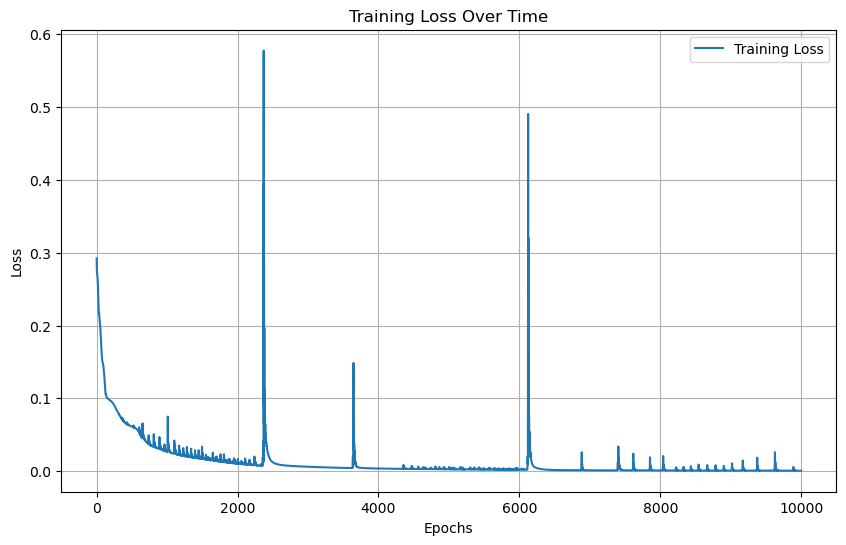

In [30]:
loss_history = network.train(epochs=10000)  # Adjust the number of epochs as needed

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
u_pred, f_pred = network.predict(X_star)
        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(usol - U_pred)

Error u: 3.947540e-02


/var/folders/38/z0l88jxs5cxc27_d0dp0r78c0000gn/T/ipykernel_31130/1101740193.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, '$t = 0.75$')

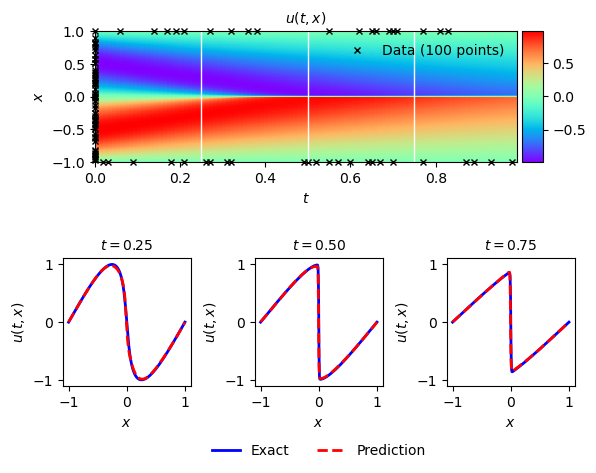

In [32]:
fig, ax = plt.subplots(1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                extent=[t.min(), t.max(), x.min(), x.max()], 
                origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,usol[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,usol[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,usol[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

# savefig('./figures/Burgers')  

In [33]:
upperBoundary = 1
lowerBoundary = -1
N = 250
N = 300

In [15]:
idx_t0 = 10
idx_t1 = 90
dt = t[idx_t1] - t[idx_t0]

In [16]:
noise_u0 = 0.0
idx_x = np.random.choice(usol.shape[1], N, replace=False) 
initialInput = x[idx_x,:]
u0 = usol[idx_t0:idx_t0+1,idx_x].T
initialOutput = u0 + noise_u0*np.std(u0)*np.random.randn(u0.shape[0], u0.shape[1])

In [17]:
idx_x

array([ 24,  84,  41, 169,  43, 125, 242, 185,  10, 122,  40,  14,  11,
       113, 224, 121,   5, 131,   2, 119, 181,  85,  91, 149, 223, 174,
       233, 147,  30, 213,  31,  53,  42, 154, 222,  83, 221,  52,  18,
        50,  93,  35, 243,  27, 188, 215, 148,  45,  46, 106, 214, 158,
        33, 109, 198,  63,  62,  51, 137, 110, 182, 184,  49, 219, 123,
       176, 197,  39,  61,  80, 145,  47,  64,  58,  26, 193, 218,  17,
       246,   0,  16, 170,  94,  82,  79, 104,  37,  65,  60, 156,   4,
        55,  29, 124, 139,  32, 133, 194, 177, 141,  15,  75, 150,  78,
       190, 126, 161, 255, 165, 187,  22, 103, 236, 249, 195,   6, 211,
        67, 146, 101, 227,  88, 241, 220,  96,  89, 254,  21, 129, 100,
       208, 120, 226, 203,  76, 231,  20, 134, 157, 207, 159, 251, 253,
       196, 130, 164,  44, 202,  99,  71, 204, 175, 228, 143,  86, 180,
       178, 217,  68, 155, 247, 132, 245,  12, 237,  13, 209, 252, 153,
       201, 173, 235, 167, 230, 162, 112, 107, 212, 250, 151,  3

In [18]:
x1 = np.vstack((lowerBoundary,upperBoundary))
x1

array([[-1],
       [ 1]])

In [19]:
x.shape

(256, 1)